In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

# Imports pour le Deep Learning (TensorFlow/Keras)
import tensorflow as tf
# Au lieu de 'from tensorflow.keras...', on utilise 'tf.keras'
# C'est la manière "officielle" recommandée par Google
Sequential = tf.keras.models.Sequential
Conv1D = tf.keras.layers.Conv1D
MaxPooling1D = tf.keras.layers.MaxPooling1D
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
BatchNormalization = tf.keras.layers.BatchNormalization
Adam = tf.keras.optimizers.Adam
AUC = tf.keras.metrics.AUC

# Imports pour l'évaluation et le déséquilibre
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Ajoute le dossier parent au 'path' pour trouver 'src'
sys.path.append('../src')
from src.preprocess import normalize_flux

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0


In [2]:
# --- Configuration des chemins ---
TRAIN_PATH = '../data/raw/train.csv'
TEST_PATH = '../data/raw/test.csv'

# --- 1. Chargement et Pré-traitement ---

print("Chargement des données...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# Correction des labels
df_train['LABEL'] = df_train['LABEL'].map({1: 0, 2: 1})
df_test['LABEL'] = df_test['LABEL'].map({1: 0, 2: 1})

# Séparation X/y
X_train_raw = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']
X_test_raw = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

# Remplir NaN
X_train_filled = X_train_raw.fillna(0)
X_test_filled = X_test_raw.fillna(0)

# Normalisation (Detrending)
print("Normalisation (detrending) des données...")
# .values convertit le DataFrame en array NumPy, ce qui est mieux pour TF
X_train_normalized = X_train_filled.apply(normalize_flux, axis=1).values
X_test_normalized = X_test_filled.apply(normalize_flux, axis=1).values
print("Normalisation terminée.")

print(f"Shape de X_train_normalized: {X_train_normalized.shape}")
print(f"Shape de y_train: {y_train.shape}")

Chargement des données...
Normalisation (detrending) des données...
Normalisation terminée.
Shape de X_train_normalized: (5087, 3197)
Shape de y_train: (5087,)


In [3]:
# 1. Reshaping des données
# On passe de (5087, 3197) à (5087, 3197, 1)
# np.newaxis ajoute une nouvelle dimension à la fin
X_train_cnn = X_train_normalized[:, :, np.newaxis]
X_test_cnn = X_test_normalized[:, :, np.newaxis]

print(f"Shape pour le CNN (X_train_cnn): {X_train_cnn.shape}")
print(f"Shape pour le CNN (X_test_cnn): {X_test_cnn.shape}")

# 2. Gérer le déséquilibre (LA CLÉ !)
# On calcule les poids pour que Keras pénalise les erreurs sur la classe '1' (Planète)

# 'balanced' va automatiquement donner un poids faible à 0 et fort à 1
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Keras attend un dictionnaire
# Poids pour la classe 0: ...
# Poids pour la classe 1: ...
class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

print(f"\nPoids des classes calculés (pour gérer le déséquilibre):")
print(class_weight_dict)

Shape pour le CNN (X_train_cnn): (5087, 3197, 1)
Shape pour le CNN (X_test_cnn): (570, 3197, 1)

Poids des classes calculés (pour gérer le déséquilibre):
{0: np.float64(0.5036633663366337), 1: np.float64(68.74324324324324)}


In [4]:
# --- 3. Définition de l'Architecture du Modèle (CNN 1D) ---

# On récupère la longueur de notre série temporelle (3197)
INPUT_SHAPE = (X_train_cnn.shape[1], 1) # (3197, 1)

model = Sequential([
    # ---- 1er Bloc Convolutif ----
    # 16 filtres de taille 5. Le "filtre" va scanner la courbe 5 points par 5
    Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=INPUT_SHAPE),
    # Réduit la taille de la série par 2 pour garder l'essentiel
    MaxPooling1D(pool_size=2),
    # Normalise les sorties pour stabiliser l'entraînement
    BatchNormalization(),

    # ---- 2e Bloc Convolutif ----
    # On double les filtres (32) pour apprendre des formes plus complexes
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # ---- 3e Bloc Convolutif ----
    # On double encore (64)
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # ---- Tête de Classification ----
    # On "aplatit" la sortie 3D en un long vecteur 1D
    Flatten(),

    # Une couche "Dense" (entièrement connectée) pour interpréter les features
    Dense(64, activation='relu'),
    # Dropout "éteint" 50% des neurones au hasard pour éviter le sur-apprentissage
    Dropout(0.5),

    # Couche de Sortie (Sigmoid)
    # Une seule sortie qui donne une probabilité entre 0 (Pas Planète) et 1 (Planète)
    Dense(1, activation='sigmoid')
])

# Affiche un résumé de notre modèle
model.summary()

C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3193, 16)       │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1596, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1596, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1592, 32)       │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 796, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 796, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 792, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 396, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 396, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25344)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,622,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,635,585 (6.24 MB)

 Trainable params: 1,635,361 (6.24 MB)

 Non-trainable params: 224 (896.00 B)

In [5]:
print("Compilation du modèle...")

# On choisit notre métrique principale : l'AUC de la courbe PR (Precision-Recall)
# C'est la même métrique que notre baseline RF, mais intégrée à Keras
# Note: Pour les versions récentes de TF, il faut utiliser tf.keras.metrics.AUC
pr_auc_metric = AUC(curve='PR', name='pr_auc')

model.compile(
    optimizer=Adam(learning_rate=0.001),     # Optimiseur standard et efficace
    loss='binary_crossentropy',              # Perte standard pour la classification binaire
    metrics=['accuracy', pr_auc_metric]      # On surveille l'AUC (PR) et l'accuracy
)

print("Début de l'entraînement...")

# On entraîne le modèle !
# - 10 epochs : Il va voir 10 fois le dataset complet.
# - batch_size=32 : Il met à jour ses poids tous les 32 exemples.
# - validation_data : Il teste sa performance sur le set de test à chaque epoch.
# - class_weight : C'est là qu'on passe notre dictionnaire !
history = model.fit(
    X_train_cnn,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    class_weight=class_weight_dict  # <--- LA CLÉ DU PROBLÈME DE DÉSÉQUILIBRE
)

print("Entraînement terminé.")

Compilation du modèle...
Début de l'entraînement...
Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.6678 - loss: 4.4158 - pr_auc: 0.0097 - val_accuracy: 0.9912 - val_loss: 0.5304 - val_pr_auc: 0.0122
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.4368 - loss: 1.6360 - pr_auc: 0.0179 - val_accuracy: 0.9298 - val_loss: 0.6765 - val_pr_auc: 0.0180
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.7380 - loss: 1.3696 - pr_auc: 0.0334 - val_accuracy: 0.2667 - val_loss: 1.1291 - val_pr_auc: 0.0131
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.7865 - loss: 0.7412 - pr_auc: 0.0505 - val_accuracy: 0.9912 - val_loss: 1.1557 - val_pr_auc: 0.0088
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.7315 - loss: 0.6219 - pr_auc: 0.0533 - val_accuracy: 0.9912 - val_loss: 1.2259 - val_pr_auc: 0.0088
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8017 - loss: 0.5444 - pr_auc: 0.0932 - v

In [6]:
print("Évaluation du modèle sur le set de test...")

# 1. Obtenir les probabilités brutes (entre 0.0 et 1.0)
y_pred_proba_cnn = model.predict(X_test_cnn).flatten()

# 2. Convertir les probabilités en classes (0 ou 1)
# On utilise un seuil standard de 0.5
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

# 3. Matrice de Confusion
print("\nMatrice de Confusion (CNN):")
#      Prédit 0 | Prédit 1
# Vrai 0
# Vrai 1
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
print(cm_cnn)

# 4. Rapport de Classification
print("\nRapport de Classification (CNN):")
print(classification_report(y_test, y_pred_cnn, target_names=['Pas de Planète (0)', 'Planète (1)']))

Évaluation du modèle sur le set de test...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

Matrice de Confusion (CNN):
[[565   0]
 [  5   0]]

Rapport de Classification (CNN):
                    precision    recall  f1-score   support

Pas de Planète (0)       0.99      1.00      1.00       565
       Planète (1)       0.00      0.00      0.00         5

          accuracy                           0.99       570
         macro avg       0.50      0.50      0.50       570
      weighted avg       0.98      0.99      0.99       570



C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

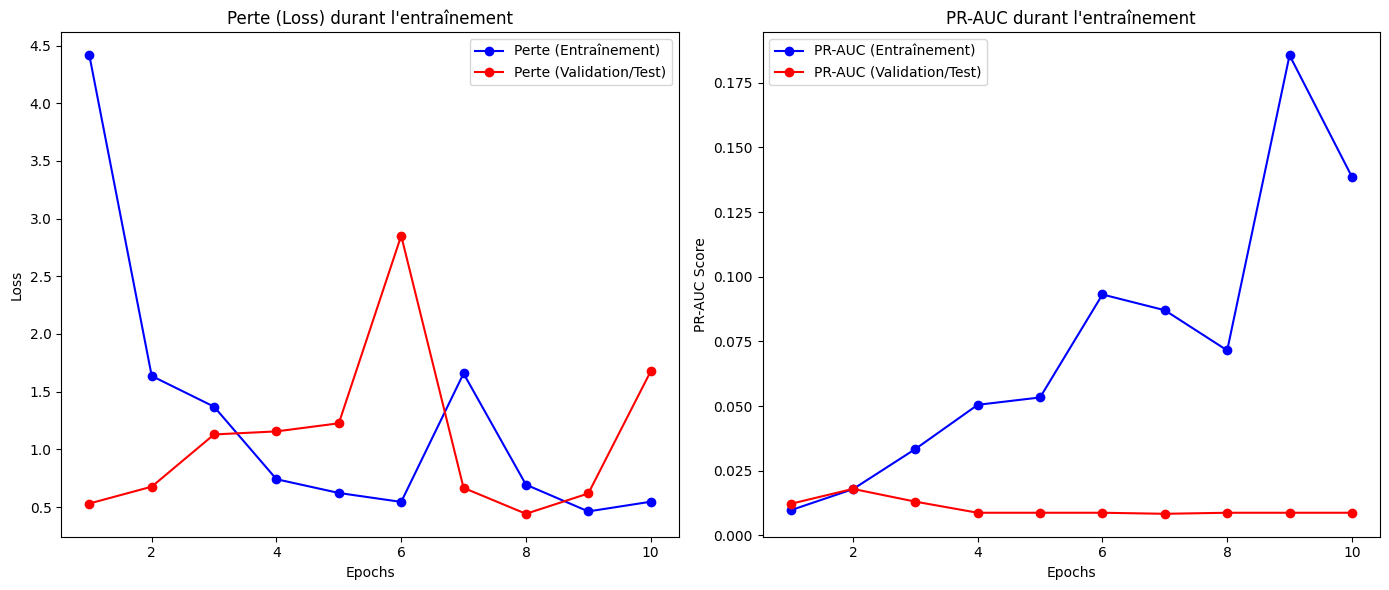

In [7]:
# Récupérer l'historique
history_dict = history.history

# Récupérer les métriques
loss = history_dict['loss']
val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']
val_pr_auc = history_dict['val_pr_auc']
epochs = range(1, len(loss) + 1)

# --- 1. Graphique de la Perte (Loss) ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Perte (Entraînement)')
plt.plot(epochs, val_loss, 'ro-', label='Perte (Validation/Test)')
plt.title('Perte (Loss) durant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- 2. Graphique de la Métrique Clé (PR-AUC) ---
plt.subplot(1, 2, 2)
plt.plot(epochs, pr_auc, 'bo-', label='PR-AUC (Entraînement)')
plt.plot(epochs, val_pr_auc, 'ro-', label='PR-AUC (Validation/Test)')
plt.title('PR-AUC durant l\'entraînement')
plt.xlabel('Epochs')
plt.ylabel('PR-AUC Score')
plt.legend()

plt.tight_layout()
plt.show()